In [39]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import tiktoken

In [43]:
models = ['gpt_oss_20b_openrouter', 'gpt_oss_120b_openrouter', 'qwen3_32b_openrouter', 'qwen3_235b_openrouter']
games = ["diagnosis_simulator_sct", "hangman_sct"]
agents = ['vanilla_llm_agent', 'private_cot_agent',
          'reactmem_overwrite_agent', 'reactmem_patch_and_replace_agent',
          'reactmem_append_and_delete_agent', 'workflow_overwrite_agent',
          'workflow_patch_and_replace_agent',
          'workflow_append_and_delete_agent', 'mem0_agent', 'amem_agent', 'lightmem_agent', 'memoryos_agent']

RESULTS_DIR = "../results/"

len_dirs = []
for model in models:
    for game in games:
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            # agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                if os.path.isdir(result_dir):
                    len_dirs.append(len(os.listdir(result_dir)))
                    if len(os.listdir(result_dir)) != 50:
                        print(len(os.listdir(result_dir)), result_dir)

print(pd.Series(len_dirs).value_counts())

2 ../results/gpt_oss_120b_openrouter/diagnosis_simulator_sct/memoryos_agent
49 ../results/qwen3_235b_openrouter/diagnosis_simulator_sct/memoryos_agent
50    94
2      1
49     1
Name: count, dtype: int64


In [44]:
results = {}
error_files = []
for model in models:
    results[model] = {}
    for game in games:
        results[model][game] = {}
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            # agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                agent_name = result_dir.split('/')[-1]
                results[model][game][agent_name] = []
                for filepath in os.listdir(result_dir):
                    filepath = os.path.join(result_dir, filepath)
                    if filepath.endswith(".json"):
                        with open(filepath, 'r') as file:
                            data = file.read()
                            if "error" in data.lower():
                                error_files.append(filepath)
                        with open(filepath, 'r') as file:
                            data = json.load(file)
                            data['filepath'] = filepath
                            interaction_log = data.get('interaction_log', [])
                            results[model][game][agent_name].append(data)

In [45]:
error_agents = list(map(lambda x: x.split('/')[-2], error_files))
error_games = list(map(lambda x: x.split('/')[-3], error_files))
error_models = list(map(lambda x: x.split('/')[-4], error_files))
print(pd.Series(error_agents).value_counts())
print(pd.Series(error_games).value_counts())
print(pd.Series(error_models).value_counts())

memoryos_agent                      108
mem0_agent                           37
reactmem_patch_and_replace_agent     12
lightmem_agent                        8
reactmem_overwrite_agent              5
amem_agent                            4
reactmem_append_and_delete_agent      3
private_cot_agent                     3
vanilla_llm_agent                     2
workflow_overwrite_agent              1
workflow_append_and_delete_agent      1
Name: count, dtype: int64
diagnosis_simulator_sct    113
hangman_sct                 71
Name: count, dtype: int64
qwen3_235b_openrouter      84
qwen3_32b_openrouter       83
gpt_oss_120b_openrouter     9
gpt_oss_20b_openrouter      8
Name: count, dtype: int64


In [46]:
sample_error_file = np.random.choice(error_files)

with open(sample_error_file, 'r') as file:
    print(sample_error_file)
    print(file.read())

../results/qwen3_32b_openrouter/diagnosis_simulator_sct/memoryos_agent/MemoryOSAgent_20251229-120711-224423.json
{
    "metadata": {
        "game": "diagnosis_simulator_sct",
        "agent_class": "MemoryOSAgent",
        "player_class": "DeterministicDiagnosisSimulatorPlayer",
        "agent_llm": {
            "name": "qwen3_32b_openrouter",
            "model_name": "qwen/qwen3-32b",
            "parsing_format": "think_tags",
            "provider_backend": "openrouter_sdk",
            "tool_parser": "openai",
            "api_config": {
                "base_url": "https://openrouter.ai/api/v1",
                "api_key_env": "OPENROUTER_API_KEY"
            },
            "generation_config": {
                "temperature": 0.3,
                "max_tokens": 2048,
                "include_reasoning": true,
                "reasoning_effort": "auto",
                "think_tag": "think"
            }
        },
        "max_turns": 20,
        "timestamp": "2025-12-29T12:11:55

In [47]:
DELETE_MISSING_EVALUATIONS = False

interaction_logs = []
evaluations = []

for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                interaction_logs.append({
                    'model': model,
                    'agent': agent,
                    'game': game,
                    'revealed_secret': result['sct']['revealed_secret'],
                    'interaction_log': result['interaction_log']
                })


for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                if 'evaluation' not in result:
                    print(f"No evaluation for {model} - {game} - {agent} - file: {result['filepath']}")
                    if DELETE_MISSING_EVALUATIONS:
                        os.remove(result['filepath'])
                    continue
                evaluation = result['evaluation']
                evaluations.append({
                            'model': model,
                            'agent': agent,
                            'game': game,
                            # 'yes_rate': evaluation['yes_rate'],
                            'yes_count': evaluation['yes_count'],
                            'more_than_one_yes': evaluation['yes_count'] > 1,
                            'zero_yes': evaluation['yes_count'] == 0,
                            'num_candidates': evaluation['num_candidates'], 
                            'revealed_secret': result['sct']['revealed_secret'],
                            # 'num_yes': int(evaluation['yes_rate'] * evaluation['num_candidates']),
                            'revealed_yes': evaluation['revealed_secret_received_yes'],
                            'ground_truth_yes': evaluation['ground_truth_secret_received_yes'],
                            'revealed_secret_received_yes': evaluation['revealed_secret_received_yes'],
                        })

evaluations = pd.DataFrame(evaluations)

interaction_logs = pd.DataFrame(interaction_logs)
# interaction_logs.agent = interaction_logs.agent.apply(lambda x: x[:-6])
first_private_states = []
for i, row in interaction_logs.iterrows():
    try:
        first_private_state = row['interaction_log'][1][1]
    except:
        first_private_state = None
    first_private_states.append(first_private_state)

interaction_logs['first_private_state'] = first_private_states

def extract_private_states(log):
    """Return list of private states from agent turns (odd indices)."""
    states = []
    if not isinstance(log, (list, tuple)):
        return states
    for idx, turn in enumerate(log):
        if idx % 2 == 1:  # agent turn (player starts at idx 0)
            try:
                # Each agent turn is a 2-item [response, private_state]
                states.append(turn[1])
            except Exception:
                states.append(None)
    return states

def lens(states):
    """Lengths in tokens for each private state (0 if None/non-string)."""
    out = []
    for s in states:
        if isinstance(s, str):
            out.append(len(tiktoken.encoding_for_model("gpt-4o").encode(s)))
        else:
            out.append(0)
    return out

# Build columns
interaction_logs["private_states"] = interaction_logs["interaction_log"].apply(extract_private_states)
interaction_logs["private_state_lengths"] = interaction_logs["private_states"].apply(lens)
interaction_logs["private_state_mean_len"] = interaction_logs["private_state_lengths"].apply(
    lambda L: float(np.mean(L)) if len(L) else np.nan
)

def get_model_size(row):
    if row['model'] == 'gpt_oss_20b_openrouter':
        return 20
    elif row['model'] == 'gpt_oss_120b_openrouter':
        return 120
    elif row['model'] == 'qwen3_32b_openrouter':
        return 32
    elif row['model'] == 'qwen3_235b_openrouter':
        return 235

evaluations['model_size'] = evaluations.apply(get_model_size, axis=1)

In [48]:
interaction_logs["public_agent"] = interaction_logs.apply(lambda x: x.interaction_log[1][0] + " " + x.interaction_log[3][0] + " " + x.interaction_log[5][0] + " " + x.interaction_log[7][0], axis=1)
leakage = []
memory_tag = []
for i, row in interaction_logs.iterrows():
    if type(evaluations.loc[i, "revealed_secret"]) == str:
        if evaluations.loc[i, "revealed_secret"].lower() in row.public_agent.lower():
            leakage.append(True)
        else:
            leakage.append(False)
    else:
        leakage.append(False)
    if "<working_memory>" in row.interaction_log[1][0]:
        memory_tag.append(True)
    else:
        memory_tag.append(False)
interaction_logs["leakage"] = leakage
interaction_logs["memory_tag"] = memory_tag
interaction_logs["leakage_memory_tag"] = interaction_logs["leakage"] & interaction_logs["memory_tag"]
evaluations["leakage"] = leakage

In [49]:
# self_consistency, leakage, false_positive, false_negative

evaluations["self_consistency"] = evaluations["revealed_secret_received_yes"] & ~evaluations["leakage"] & (evaluations["yes_count"] == 1)
evaluations["non_confirmed"] = ~evaluations["revealed_secret_received_yes"] & ~evaluations["leakage"] & (evaluations["yes_count"] >= 1)
evaluations["all_denials"] = ~evaluations["leakage"] & (evaluations["yes_count"] == 0)
evaluations["confirmed_multiple"] = evaluations["revealed_secret_received_yes"] & ~evaluations["leakage"] & (evaluations["yes_count"] > 1)

In [50]:
evaluations[evaluations['agent'] == 'memoryos_agent'].self_consistency.mean()

np.float64(0.05397727272727273)

In [51]:
interaction_logs = interaction_logs[interaction_logs.agent.isin(agents)]
evaluations = evaluations[evaluations.agent.isin(agents)]

In [52]:
print(evaluations.groupby(['model','agent'])['revealed_yes'].mean())    
print(evaluations.groupby(['model','agent'])['more_than_one_yes'].mean())    
print(evaluations.groupby(['model','agent'])['zero_yes'].mean())    

model                    agent                           
gpt_oss_120b_openrouter  amem_agent                          0.450000
                         lightmem_agent                      0.610000
                         mem0_agent                          0.490000
                         memoryos_agent                      0.339623
                         private_cot_agent                   0.680000
                         reactmem_append_and_delete_agent    0.670000
                         reactmem_overwrite_agent            0.770000
                         reactmem_patch_and_replace_agent    0.730000
                         vanilla_llm_agent                   0.410000
                         workflow_append_and_delete_agent    0.990000
                         workflow_overwrite_agent            0.980000
                         workflow_patch_and_replace_agent    1.000000
gpt_oss_20b_openrouter   amem_agent                          0.130000
                         lightme

## Figures

In [53]:
_AGENT_MAP = {
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    "mem0_agent": ("Mem0", "Baseline"),
    "amem_agent": ("A-Mem", "Baseline"),
    "lightmem_agent": ("LightMem", "Baseline"),
    "memoryos_agent": ("MemoryOS", "Baseline"),
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
    "#FF4D00", "#FFDE21"
]

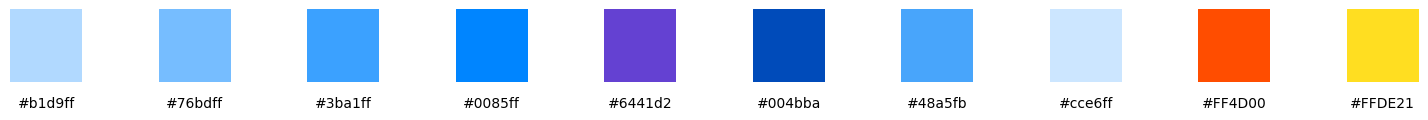

In [54]:
def plot_color_squares(hex_colors):
    num_colors = len(hex_colors)
    num_rows = 1
    num_cols = num_colors
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 1.5, num_rows * 1.5))
    if num_colors == 1:
        ax = [ax]
    for i, color in enumerate(hex_colors):
        ax[i].add_patch(patches.Rectangle((0, 0), 1, 1, color=color))
        ax[i].text(0.5, -0.2, color, ha='center', va='top', fontsize=10)
        ax[i].axis('off')
        ax[i].set_aspect('equal') # Ensure the patches are squares
    plt.tight_layout(rect=[0, 0.1, 1, 0.95]) # Adjust layout to prevent text overlap
    plt.show()
plot_color_squares(PALETTE_LIST)


### Statistical Test

In [55]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

df = evaluations[['model', 'agent', 'game', 'self_consistency']]

# 1. Configuration
proposed_agents = [
    'private_cot_agent',
    'reactmem_overwrite_agent', 
    'reactmem_patch_and_replace_agent', 
    'reactmem_append_and_delete_agent', 
    'workflow_overwrite_agent', 
    'workflow_patch_and_replace_agent', 
    'workflow_append_and_delete_agent'
]

baselines = [
    'vanilla_llm_agent', 
    'mem0_agent', 
    'amem_agent', 
    'lightmem_agent',
    'memoryos_agent'
]

# 2. Pre-calculate counts STRATIFIED by Model
# We now group by ['game', 'model', 'agent'] to avoid mixing different model capabilities
counts_df = df.groupby(['game', 'model', 'agent'])['self_consistency'].value_counts().unstack(fill_value=0)

# Ensure columns exist
if True not in counts_df.columns: counts_df[True] = 0
if False not in counts_df.columns: counts_df[False] = 0

results = []

# Get unique games and models present in the data
games = df['game'].unique()
models = df['model'].unique()

print(f"Dataframe loaded. Found {len(models)} models and {len(games)} games.")

# 3. Iterate and Test
for game in games:
    for model in models:
        # Skip if this model/game combo doesn't exist in data
        if counts_df.index.get_level_values('game').isin([game]).sum() == 0:
            continue
            
        for prop_agent in proposed_agents:
            # Check existence
            if (game, model, prop_agent) not in counts_df.index:
                continue
                
            prop_success = counts_df.loc[(game, model, prop_agent), True]
            prop_fail = counts_df.loc[(game, model, prop_agent), False]
            prop_total = prop_success + prop_fail
            
            p_values = []
            baseline_names = []
            base_stats = [] # To store win rates for display
            
            for base_agent in baselines:
                if (game, model, base_agent) not in counts_df.index:
                    continue
                
                base_success = counts_df.loc[(game, model, base_agent), True]
                base_fail = counts_df.loc[(game, model, base_agent), False]
                
                # Fisher's Exact Test
                table = [[prop_success, prop_fail], 
                         [base_success, base_fail]]
                _, p_val = stats.fisher_exact(table, alternative='greater')
                
                p_values.append(p_val)
                baseline_names.append(base_agent)
                base_stats.append(f"{base_success/(base_success+base_fail):.1%}")
                
            # Apply Correction
            if p_values:
                reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
                
                for base, base_stat, p_raw, p_corr, sig in zip(baseline_names, base_stats, p_values, pvals_corrected, reject):
                    results.append({
                        'Game': game,
                        'Model': model,
                        'Proposed Agent': prop_agent,
                        'Baseline': base,
                        'Prop Win%': f"{prop_success/prop_total:.1%}",
                        'Base Win%': base_stat,
                        'P-Value (Corr)': p_corr,
                        'Significant': sig
                    })

# 4. Display Results
results_df = pd.DataFrame(results)

def highlight_sig(s):
    return ['background-color: #000000' if v else 'background-color: #f8d7da' for v in s]

# Sort for readability
results_df = results_df.sort_values(['Game', 'Model', 'Proposed Agent'])

print(f"Total hypothesis tests run: {len(results_df)}")
# display(results_df.style.apply(highlight_sig, subset=['Significant'])
#         .format({'P-Value (Corr)': '{:.2e}'}))

Dataframe loaded. Found 4 models and 2 games.
Total hypothesis tests run: 280


### Table

In [56]:
import pandas as pd
import numpy as np

def generate_icml_table(evaluations_df, results_df, bold_best=True, underline_second=True):
    """
    Generates a LaTeX table string for ICML submission from the evaluations DataFrame.
    
    Structure:
    - Columns: Games (Top) -> Model Family (Middle) -> Model Size (Bottom)
    - Rows: Grouped by Agent Type (Baselines, Ours Auto, Ours Workflow)
    - Font: Footnote size
    """
    
    # --- 1. CONFIGURATION & MAPPING ---
    
    relevant_agents = [
        "vanilla_llm_agent", "private_cot_agent", "mem0_agent", "amem_agent", "lightmem_agent", "memoryos_agent",
        "reactmem_overwrite_agent", "reactmem_patch_and_replace_agent", "reactmem_append_and_delete_agent",
        "workflow_overwrite_agent", "workflow_patch_and_replace_agent", "workflow_append_and_delete_agent"
    ]
    
    model_meta = {
        'gpt_oss_20b_openrouter':  {'family': 'GPT-OSS', 'size': '20B'},
        'gpt_oss_120b_openrouter': {'family': 'GPT-OSS', 'size': '120B'},
        'qwen3_32b_openrouter':    {'family': 'Qwen3',   'size': '32B'},
        'qwen3_235b_openrouter':   {'family': 'Qwen3',   'size': '235B'}
    }
    
    game_map = {
        "diagnosis_simulator_sct": "Diagnosis Simulator",
        "hangman_sct": "Hangman"
    }

    groups = {
        "Baselines": [
            "vanilla_llm_agent", 
            "mem0_agent", "amem_agent", "lightmem_agent", "memoryos_agent",
        ],
        "Upper Bound": [
            "private_cot_agent"
        ],
        "Ours: Autonomous Agents": [
            "reactmem_overwrite_agent", "reactmem_patch_and_replace_agent", "reactmem_append_and_delete_agent"
        ],
        "Ours: Workflow Agents": [
            "workflow_overwrite_agent", "workflow_patch_and_replace_agent", "workflow_append_and_delete_agent"
        ]
    }
    
    agent_display_map = {
        "vanilla_llm_agent": "Vanilla LLM",
        "private_cot_agent": "Private CoT",
        "mem0_agent": "Mem0",
        "amem_agent": "A-Mem",
        "memoryos_agent": "MemoryOS",
        "lightmem_agent": "LightMem",
        "reactmem_overwrite_agent": "Overwrite",
        "reactmem_patch_and_replace_agent": "Patch and Replace",
        "reactmem_append_and_delete_agent": "Append and Delete",
        "workflow_overwrite_agent": "Overwrite",
        "workflow_patch_and_replace_agent": "Patch and Replace",
        "workflow_append_and_delete_agent": "Append and Delete",
    }

    game_order = ["hangman_sct", "diagnosis_simulator_sct"]
    model_order = ['gpt_oss_20b_openrouter', 'gpt_oss_120b_openrouter', 'qwen3_32b_openrouter', 'qwen3_235b_openrouter']

    # --- 2. DATA PROCESSING ---
    
    df = evaluations_df[evaluations_df['agent'].isin(relevant_agents)].copy()
    
    pivot = df.pivot_table(
        index='agent', 
        columns=['game', 'model'], 
        values='self_consistency', 
        aggfunc='mean'
    ) * 100 

    # --- 3. SIGNIFICANCE PROCESSING ---
    # Create lookup map: (agent, game, model) -> bool
    significance_lookup = {}
    
    if results_df is not None and not results_df.empty:
        # Group by Game, Model, Proposed Agent
        # results_df expected columns: ['Game', 'Model', 'Proposed Agent', 'Significant', ...]
        grouped = results_df.groupby(['Game', 'Model', 'Proposed Agent'])
        
        for name, group in grouped:
            game, model, agent = name
            # Only mark as significant if it is significantly better than ALL baselines compared against
            if group['Significant'].all():
                significance_lookup[(agent, game, model)] = True

    # --- 4. LATEX CONSTRUCTION ---
    
    latex = []
    latex.append(r"\begin{table}[t]")
    latex.append(r"\centering")
    
    # CHANGE: Removed \resizebox, added \footnotesize
    latex.append(r"\footnotesize") 
    
    # l = left align (agent name), c = center (data) * 8 columns
    latex.append(r"\begin{tabular}{l" + "c" * (len(game_order) * len(model_order)) + "}")
    latex.append(r"\toprule")
    
    # -- Header Row 1: Games --
    header1 = []
    header1.append("") 
    for game in game_order:
        game_name = game_map.get(game, game)
        header1.append(r"\multicolumn{4}{c}{\textbf{" + game_name + r"}}")
    latex.append(" & ".join(header1) + r" \\")
    
    # -- Header Row 2: Model Families --
    latex.append(r"\cmidrule(lr){2-5} \cmidrule(lr){6-9}") 
    
    header2 = []
    header2.append("") 
    for _ in game_order:
        header2.append(r"\multicolumn{2}{c}{GPT-OSS}")
        header2.append(r"\multicolumn{2}{c}{Qwen3}")
        
    latex.append(" & ".join(header2) + r" \\")
    
    # -- Header Row 3: Model Sizes --
    latex.append(r"\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9}")
    
    header3 = []
    header3.append(r"\textit{Method}") 
    for _ in game_order:
        for model in model_order:
            size_label = model_meta[model]['size']
            header3.append(size_label)
            
    latex.append(" & ".join(header3) + r" \\")
    latex.append(r"\midrule")

    # --- 5. ROW GENERATION ---

    for group_name, agent_list in groups.items():
        # Section Header
        latex.append(r"\multicolumn{9}{l}{\textbf{" + group_name + r"}} \\")
        
        for agent in agent_list:
            if agent not in pivot.index:
                continue
                
            row_str = []
            # Agent Name
            row_str.append(f"\\hspace{{3mm}}{agent_display_map.get(agent, agent)}")
            
            for game in game_order:
                for model in model_order:
                    try:
                        val = pivot.loc[agent, (game, model)]
                    except KeyError:
                        val = np.nan
                    
                    if pd.isna(val):
                        row_str.append("-")
                        continue

                    # Formatting Logic
                    col_values = pivot.loc[relevant_agents, (game, model)].dropna()
                    sorted_vals = sorted(col_values, reverse=True)
                    
                    max_val = sorted_vals[0] if len(sorted_vals) > 0 else 0
                    second_val = sorted_vals[1] if len(sorted_vals) > 1 else 0
                    
                    formatted_num = f"{val:.0f}"
                    
                    if bold_best and val >= max_val:
                        formatted_num = r"\textbf{" + formatted_num + "}"
                    elif underline_second and val >= second_val:
                        if val < max_val: 
                            formatted_num = r"\underline{" + formatted_num + "}"
                    
                    # Add Asterisk if Significant against ALL baselines
                    if significance_lookup.get((agent, game, model), False):
                        formatted_num += r"*"
                            
                    row_str.append(formatted_num)
            
            latex.append(" & ".join(row_str) + r" \\")
        
        if group_name != "Ours: Workflow Agents":
            latex.append(r"\midrule")

    # --- 6. FOOTER ---
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\caption{Self-Consistency Accuracy (\%) on the SCT benchmark. \textbf{Bold} indicates the best performing method per column, \underline{underlined} indicates the second best. An asterisk (*) indicates statistically significant superiority over all baselines ($p < 0.05$, Fisher's exact test with Holm-Bonferroni correction).}")
    latex.append(r"\label{tab:main_results}")
    latex.append(r"\end{table}")
    
    return "\n".join(latex)

# Example call (commented out as evaluations/results_df are expected in notebook environment)
print(generate_icml_table(evaluations, results_df))

\begin{table}[t]
\centering
\footnotesize
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{4}{c}{\textbf{Hangman}} & \multicolumn{4}{c}{\textbf{Diagnosis Simulator}} \\
\cmidrule(lr){2-5} \cmidrule(lr){6-9}
 & \multicolumn{2}{c}{GPT-OSS} & \multicolumn{2}{c}{Qwen3} & \multicolumn{2}{c}{GPT-OSS} & \multicolumn{2}{c}{Qwen3} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9}
\textit{Method} & 20B & 120B & 32B & 235B & 20B & 120B & 32B & 235B \\
\midrule
\multicolumn{9}{l}{\textbf{Baselines}} \\
\hspace{3mm}Vanilla LLM & 2 & 12 & 4 & 12 & 2 & 26 & 12 & 14 \\
\hspace{3mm}Mem0 & 2 & 6 & 4 & 8 & 2 & 50 & \textbf{20} & 18 \\
\hspace{3mm}A-Mem & 6 & 6 & 2 & 2 & 4 & 32 & 12 & 28 \\
\hspace{3mm}LightMem & 0 & 6 & 6 & 8 & 0 & 38 & 10 & 10 \\
\hspace{3mm}MemoryOS & 0 & 14 & 4 & 4 & 0 & 33 & 8 & 6 \\
\midrule
\multicolumn{9}{l}{\textbf{Upper Bound}} \\
\hspace{3mm}Private CoT & \textbf{94}* & 82* & \textbf{94}* & 98* & \underline{66}* & 54 & 16 & \textbf{82}* \\
\midru

### Failure Mode

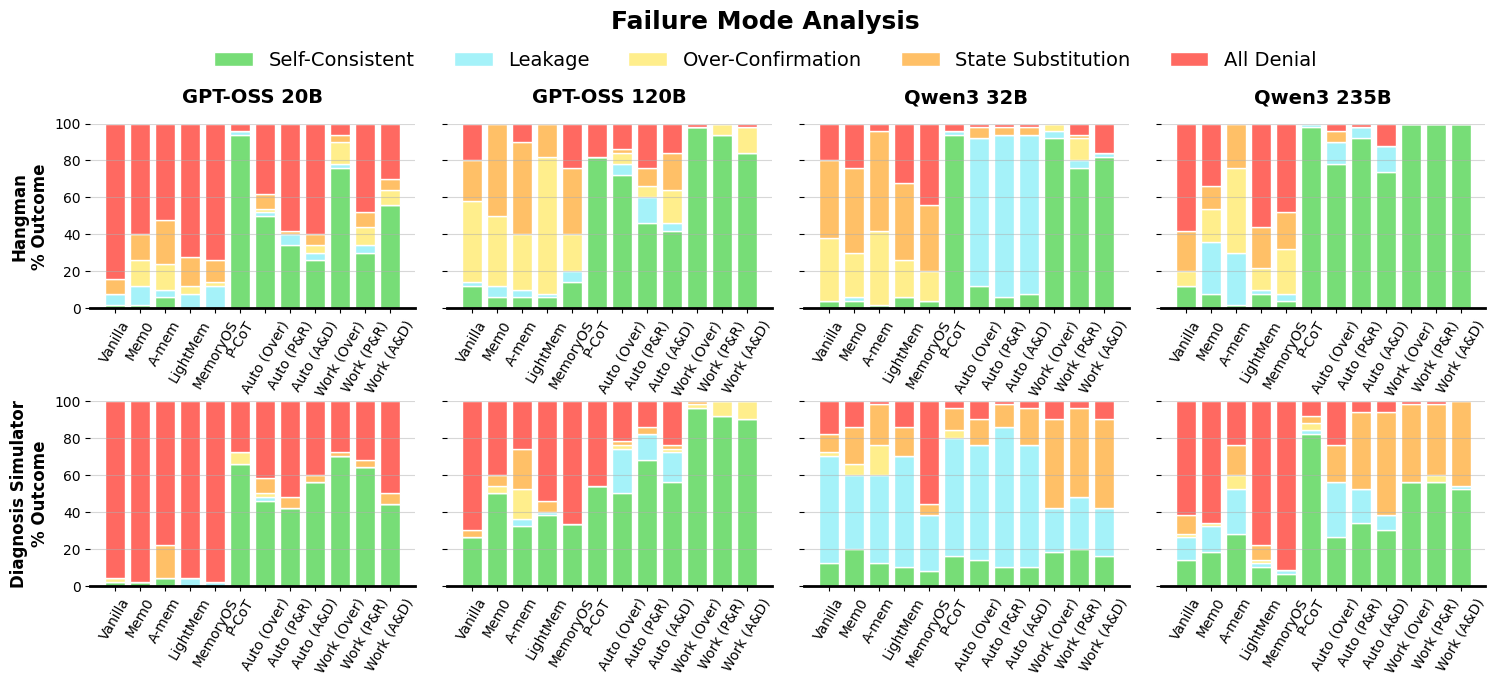

In [57]:
def plot_failure_modes(evaluations_df):
    """
    Generates a 2x4 grid of stacked bar charts showing the breakdown of outcomes.
    Outcomes:
      1. Success (Unique Correct)
      2. Superposition (Multiple Yes)
      3. Silence/Other (Zero Yes or Wrong Single)
    """
    
    agent_order = [
        'vanilla_llm_agent', 
        'mem0_agent', 'amem_agent', 'lightmem_agent', 'memoryos_agent', 'private_cot_agent',
        'reactmem_overwrite_agent', 'reactmem_patch_and_replace_agent', 'reactmem_append_and_delete_agent',
        'workflow_overwrite_agent', 'workflow_patch_and_replace_agent', 'workflow_append_and_delete_agent'
    ]
    
    agent_labels = {
        'vanilla_llm_agent': 'Vanilla',
        'private_cot_agent': 'P-CoT',
        'mem0_agent': 'Mem0',
        'amem_agent': 'A-mem',
        'lightmem_agent': 'LightMem',
        'memoryos_agent': 'MemoryOS',
        'reactmem_overwrite_agent': 'Auto (Over)',
        'reactmem_patch_and_replace_agent': 'Auto (P&R)',
        'reactmem_append_and_delete_agent': 'Auto (A&D)',
        'workflow_overwrite_agent': 'Work (Over)',
        'workflow_patch_and_replace_agent': 'Work (P&R)',
        'workflow_append_and_delete_agent': 'Work (A&D)'
    }

    
    colors = PALETTE_LIST

    games = ["hangman_sct", "diagnosis_simulator_sct"]
    game_names = {"diagnosis_simulator_sct": "Diagnosis Simulator", "hangman_sct": "Hangman"}
    
    models = ['gpt_oss_20b_openrouter', 'gpt_oss_120b_openrouter', 'qwen3_32b_openrouter', 'qwen3_235b_openrouter']
    model_names = {
        'gpt_oss_20b_openrouter': 'GPT-OSS 20B', 
        'gpt_oss_120b_openrouter': 'GPT-OSS 120B',
        'qwen3_32b_openrouter': 'Qwen3 32B', 
        'qwen3_235b_openrouter': 'Qwen3 235B'
    }

    fig, axes = plt.subplots(2, 4, figsize=(18, 6), sharey=True)
    plt.subplots_adjust(hspace=0.5, wspace=0.1) # Adjust spacing

    for g_idx, game in enumerate(games):
        for m_idx, model in enumerate(models):
            ax = axes[g_idx, m_idx]
            
            subset = evaluations_df[
                (evaluations_df['game'] == game) & 
                (evaluations_df['model'] == model) &
                (evaluations_df['agent'].isin(agent_order))
            ].copy()
            
            plot_data = []
            for agent in agent_order:
                agent_sub = subset[subset['agent'] == agent]
                if len(agent_sub) == 0:
                    plot_data.append([0, 0, 0])
                    continue
                total = len(agent_sub)
                n_consistent = agent_sub['self_consistency'].sum()
                n_leakage = agent_sub['leakage'].sum()
                n_multiple = agent_sub['confirmed_multiple'].sum()
                n_wrong = agent_sub['non_confirmed'].sum()
                n_silence = agent_sub['all_denials'].sum()
                plot_data.append([
                    (n_consistent/total)*100, 
                    (n_leakage/total)*100,
                    (n_multiple/total)*100, 
                    (n_wrong/total)*100,
                    (n_silence/total)*100
                ])
            
            df_plot = pd.DataFrame(plot_data, columns=['Consistent', 'Leakage', 'Multiple', 'Wrong', 'Silence'], index=agent_order)
            x_indices = np.arange(len(agent_order))

            labels = ['Self-Consistent', 'Leakage', 'Over-Confirmation', 'State Substitution', 'All Denial']
            
            ax.bar(x_indices, df_plot['Consistent'], color=colors[0], edgecolor='white', width=0.8, label=labels[0])

            ax.bar(x_indices, df_plot['Leakage'], color=colors[1], bottom=df_plot['Consistent'], 
                   edgecolor='white', width=0.8, label=labels[1])
            
            ax.bar(x_indices, df_plot['Multiple'], bottom=df_plot['Consistent'] + df_plot['Leakage'], 
                   color=colors[2], edgecolor='white', width=0.8, label=labels[2])

            ax.bar(x_indices, df_plot['Wrong'], bottom=df_plot['Consistent'] + df_plot['Leakage'] + df_plot['Multiple'], 
                   color=colors[3], edgecolor='white', width=0.8, label=labels[3])
            
            ax.bar(x_indices, df_plot['Silence'], bottom=df_plot['Consistent'] + df_plot['Leakage'] + df_plot['Multiple'] + df_plot['Wrong'], 
                   color=colors[4], edgecolor='white', width=0.8, label=labels[4])

            ax.set_xticks(x_indices)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_linewidth(2)
            ax.set_xticklabels([agent_labels[a] for a in agent_order], rotation=60, fontsize=10)
            ax.grid(axis='y', linestyle='-', alpha=0.5)
            
            if m_idx == 0:
                ax.set_ylabel(f"{game_names[game]}\n% Outcome", fontsize=12, fontweight='bold')

            
            if g_idx == 0:
                ax.set_title(model_names[model], fontsize=14, fontweight='bold', pad=15)

    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=5, fontsize=14, frameon=False)
    
    plt.suptitle(r"Failure Mode Analysis", fontsize=18, y=1.07, fontweight='bold')
    
    return fig

# Run it
PALETTE_LIST = ['#008000', '#FFA500', '#FF0000']
PALETTE_LIST = ['#77dd77', '#a5f2f9', '#ffee8c',  '#ffc067', '#ff6961']
# PALETTE_LIST = ['#45ff17', '#ff5c00', '#ff991c', '#ff073a']
plot_failure_modes(evaluations)
plt.show()

### Scale is not a fix

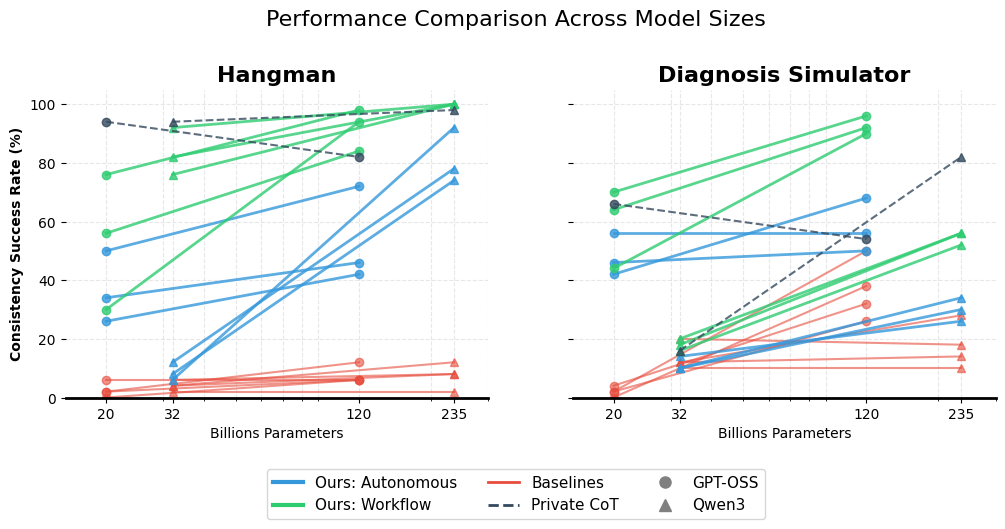

In [58]:
def plot_scale_impact(evaluations_df):
    """
    Generates a 1x2 Scale Impact Plot (Slope Chart).
    Visualizes that increasing model parameters (X-axis) does not solve the consistency problem for POCAs.
    """
    import matplotlib.ticker as ticker

    # --- CONFIGURATION ---
    
    # 1. Define Groups for Coloring/Styling
    # We will group agents to reduce visual clutter
    agent_groups = {
        "Baselines": [
            'vanilla_llm_agent', 'mem0_agent', 'amem_agent', 'lightmem_agent'
        ],
        "Ours (Autonomous)": [
            'reactmem_overwrite_agent', 'reactmem_patch_and_replace_agent', 'reactmem_append_and_delete_agent'
        ],
        "Ours (Workflow)": [
            'workflow_overwrite_agent', 'workflow_patch_and_replace_agent', 'workflow_append_and_delete_agent'
        ],
        "Oracle": ['private_cot_agent'] # Optional: Plot separately or grouping with Baselines
    }
    
    # Map for Legend
    agent_display_map = {
        'vanilla_llm_agent': 'Vanilla',
        'mem0_agent': 'Mem0',
        'amem_agent': 'Amem',
        'lightmem_agent': 'LightMem',
        'reactmem_overwrite_agent': 'Auto (Over)',
        'reactmem_patch_and_replace_agent': 'Auto (P&R)',
        'reactmem_append_and_delete_agent': 'Auto (A&D)',
        'workflow_overwrite_agent': 'Work (Over)',
        'workflow_patch_and_replace_agent': 'Work (P&R)',
        'workflow_append_and_delete_agent': 'Work (A&D)',
        'private_cot_agent': 'P-CoT (Oracle)'
    }

    # 2. Define Families
    # We need to connect lines only within the same model family
    families = {
        'gpt_oss': {20: 'gpt_oss_20b_openrouter', 120: 'gpt_oss_120b_openrouter'},
        'qwen': {32: 'qwen3_32b_openrouter', 235: 'qwen3_235b_openrouter'}
    }

    # 3. Colors & Styles
    # Using a high-contrast palette
    # Group Colors: Baselines=Gray/Red, Auto=Blue, Work=Green, Oracle=Black
    group_colors = {
        "Baselines": "#e74c3c",          # Red (Failure)
        "Ours (Autonomous)": "#3498db",  # Blue
        "Ours (Workflow)": "#2ecc71",    # Green
        "Oracle": "#34495e"              # Dark Slate
    }
    
    # Markers for families
    family_markers = {'gpt_oss': 'o', 'qwen': '^'} # Circle vs Triangle
    
    # --- DATA PREP ---
    # Calculate Mean Success % per Agent/Model/Game
    df_agg = evaluations_df.groupby(['game', 'model', 'agent', 'model_size'])['self_consistency'].mean().reset_index()
    df_agg['self_consistency'] = df_agg['self_consistency'] * 100 # To Percentage

    games = ["hangman_sct", "diagnosis_simulator_sct"]
    game_names = {"diagnosis_simulator_sct": "Diagnosis Simulator", "hangman_sct": "Hangman"}

    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    for g_idx, game in enumerate(games):
        ax = axes[g_idx]
        
        # Filter for Game
        game_data = df_agg[df_agg['game'] == game]
        
        # Plot Lines
        for agent_cat, agents_in_cat in agent_groups.items():
            color = group_colors.get(agent_cat, "black")
            
            for agent in agents_in_cat:
                agent_subset = game_data[game_data['agent'] == agent]
                
                # Iterate over families to draw lines connecting Small -> Large
                for family_name, family_map in families.items():
                    # Get data for this family (e.g. 20B and 120B)
                    fam_subset = agent_subset[agent_subset['model_size'].isin(family_map.keys())].sort_values('model_size')
                    
                    if len(fam_subset) == 2:
                        # Draw Line
                        # If Baseline, make it dashed/lighter to emphasize failure? 
                        # No, make it Solid Red to show the flatline clearly.
                        # Use alpha to distinguish individual agents slightly
                        
                        linestyle = '--' if agent_cat == "Oracle" else '-'
                        alpha = 0.6 if agent_cat == "Baselines" else 0.8
                        linewidth = 2 if "Ours" in agent_cat else 1.5
                        
                        ax.plot(
                            fam_subset['model_size'], 
                            fam_subset['self_consistency'], 
                            marker=family_markers[family_name], 
                            color=color, 
                            linestyle=linestyle,
                            linewidth=linewidth,
                            alpha=alpha,
                            label=agent_cat if (g_idx==0 and family_name=='qwen' and agent==agents_in_cat[0]) else ""
                        )
                        
                        # Annotate specific agents at the end of the line (on the rightmost point)
                        # Only for the largest model to avoid clutter
                        large_point = fam_subset.iloc[-1]
                        # Only annotate "Ours" or specific outliers to keep it clean
                        # (Optional customization based on preference)

    
        # Formatting
        ax.set_title(game_names[game], fontsize=16, fontweight='bold')
        ax.set_xscale('log')
        ax.set_xlabel("Billions Parameters", fontsize=10)
        
        # Custom Ticks for Log Scale
        ax.set_xticks([20, 32, 120, 235])
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.set_xlim(15, 300)
        
        if g_idx == 0:
            ax.set_ylabel("Consistency Success Rate (%)", fontsize=10, fontweight='bold')
            ax.set_ylim(0, 105)
        
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)

    # Custom Legend
    # Create custom handles for the legend to simplify it
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=group_colors["Ours (Autonomous)"], lw=3, label='Ours: Autonomous'),
        Line2D([0], [0], color=group_colors["Ours (Workflow)"], lw=3, label='Ours: Workflow'),
        Line2D([0], [0], color=group_colors["Baselines"], lw=2, label='Baselines'),
        Line2D([0], [0], color=group_colors["Oracle"], lw=2, linestyle='--', label='Private CoT'),
        Line2D([0], [0], marker='o', color='gray', label='GPT-OSS', markersize=8, linestyle='None'),
        Line2D([0], [0], marker='^', color='gray', label='Qwen3', markersize=8, linestyle='None')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=11)
    plt.suptitle("Performance Comparison Across Model Sizes", fontsize=16, y=1.08)
    
    return fig

# Run
PALETTE_LIST = ['#008000', '#FFA500', '#FF0000']
plot_scale_impact(evaluations)
plt.show()

### EFFICIENCY

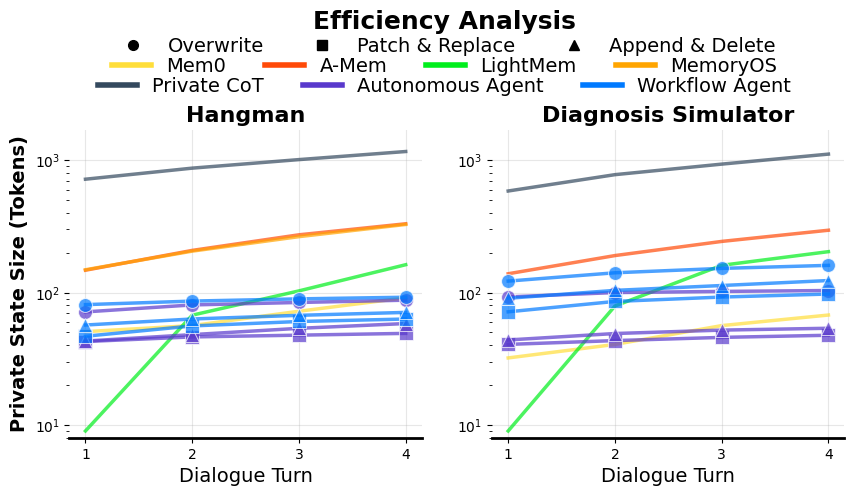

In [59]:
def plot_efficiency_all(interaction_logs_df):
    """
    Generates a 1x2 Efficiency Plot (Line Chart) for ALL agents.
    Visualizes the token cost of maintaining state over time.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from matplotlib.lines import Line2D

    # --- CONFIGURATION ---

    fontsize = 14
    
    # Colors by group
    BASELINE_COLORS = {
        'private_cot_agent': '#34495e',
        'mem0_agent': '#FFDE3A',
        'amem_agent': '#FF4A08',
        'lightmem_agent': '#00EE1C',
        'memoryos_agent': '#FFA500'
    }
    AUTO_COLOR = '#5939CC'  # Blue for all Autonomous agents
    WORK_COLOR = '#007AFF'  # Green for all Workflow agents
    
    # Markers for operation types
    MARKER_OVERWRITE = 'o'
    MARKER_PATCH_REPLACE = 's'
    MARKER_APPEND_DELETE = '^'

    baseline_config = {
        'private_cot_agent': {'label': 'Private CoT', 'color': BASELINE_COLORS['private_cot_agent']},
        'mem0_agent': {'label': 'Mem0', 'color': BASELINE_COLORS['mem0_agent']},
        'amem_agent': {'label': 'A-Mem', 'color': BASELINE_COLORS['amem_agent']},
        'lightmem_agent': {'label': 'LightMem', 'color': BASELINE_COLORS['lightmem_agent']},
        'memoryos_agent': {'label': 'MemoryOS', 'color': BASELINE_COLORS['memoryos_agent']}
    }
    
    ours_config = {
        'reactmem_overwrite_agent': {'label': 'Auto (Over)', 'color': AUTO_COLOR, 'marker': MARKER_OVERWRITE},
        'reactmem_patch_and_replace_agent': {'label': 'Auto (P&R)', 'color': AUTO_COLOR, 'marker': MARKER_PATCH_REPLACE},
        'reactmem_append_and_delete_agent': {'label': 'Auto (A&D)', 'color': AUTO_COLOR, 'marker': MARKER_APPEND_DELETE},
        'workflow_overwrite_agent': {'label': 'Work (Over)', 'color': WORK_COLOR, 'marker': MARKER_OVERWRITE},
        'workflow_patch_and_replace_agent': {'label': 'Work (P&R)', 'color': WORK_COLOR, 'marker': MARKER_PATCH_REPLACE},
        'workflow_append_and_delete_agent': {'label': 'Work (A&D)', 'color': WORK_COLOR, 'marker': MARKER_APPEND_DELETE},
    }

    games = ["hangman_sct", "diagnosis_simulator_sct"]
    game_names = {"diagnosis_simulator_sct": "Diagnosis Simulator", "hangman_sct": "Hangman"}

    # --- DATA PROCESSING ---
    
    plot_data = []
    all_agents = list(baseline_config.keys()) + list(ours_config.keys())
    
    df = interaction_logs_df[interaction_logs_df['agent'].isin(all_agents)].copy()
    
    for idx, row in df.iterrows():
        agent = row['agent']
        game = row['game']
        lengths = row['private_state_lengths'] 
        
        if not isinstance(lengths, list) or len(lengths) == 0:
            continue

        for t, val in enumerate(lengths):
            plot_data.append({
                'agent': agent,
                'game': game,
                'turn': t + 1, 
                'tokens': val
            })
            
    df_plot = pd.DataFrame(plot_data)
    
    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for g_idx, game in enumerate(games):
        ax = axes[g_idx]
        subset = df_plot[df_plot['game'] == game]
        
        if subset.empty:
            continue
        
        # Plot BASELINES (no markers)
        baseline_subset = subset[subset['agent'].isin(baseline_config.keys())]
        if not baseline_subset.empty:
            baseline_palette = {agent: conf['color'] for agent, conf in baseline_config.items()}
            sns.lineplot(
                data=baseline_subset,
                x='turn',
                y='tokens',
                hue='agent',
                palette=baseline_palette,
                ax=ax,
                alpha=0.7,
                linewidth=2.5,
                legend=False, 
                errorbar=None
            )
        
        # Plot OURS (with markers)
        ours_subset = subset[subset['agent'].isin(ours_config.keys())]
        if not ours_subset.empty:
            ours_palette = {agent: conf['color'] for agent, conf in ours_config.items()}
            ours_markers = {agent: conf['marker'] for agent, conf in ours_config.items()}
            sns.lineplot(
                data=ours_subset,
                x='turn',
                y='tokens',
                hue='agent',
                style='agent',
                palette=ours_palette,
                markers=ours_markers,
                dashes=False,
                ax=ax,
                alpha=0.7,
                linewidth=2.5,
                markersize=10,
                legend=False, 
                errorbar=None
            )
        
        # Formatting
        ax.set_title(game_names[game], fontsize=16, fontweight='bold')
        ax.set_xlabel("Dialogue Turn", fontsize=fontsize)
        if g_idx == 0:
            ax.set_ylabel("Private State Size (Tokens)", fontsize=fontsize, fontweight='bold')
        else:
            ax.set_ylabel("")
            
        ax.grid(True, linestyle='-', alpha=0.3)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(8, 1700)
        ax.set_yscale('log')
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            
    
    # Family Legend (Colors)
    fam_1_handles = []
    fam_2_handles = []
    # append the title to the legend
    for agent in ['mem0_agent', 'amem_agent', 'lightmem_agent', 'memoryos_agent']:
        if agent in baseline_config:
            conf = baseline_config[agent]
            # h = plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=conf['color'],
            #                markeredgecolor='white', markersize=9, label=conf['label'])
            h = plt.Line2D([0], [0], color=conf['color'], lw=4, label=conf['label'])
            fam_1_handles.append(h)
    
    fam_2_handles.append(plt.Line2D([0], [0], color=baseline_config['private_cot_agent']['color'], lw=4, label='Private CoT'))
    fam_2_handles.append(plt.Line2D([0], [0], color=ours_config['reactmem_overwrite_agent']['color'], lw=4, label='Autonomous Agent'))
    fam_2_handles.append(plt.Line2D([0], [0], color=ours_config['workflow_overwrite_agent']['color'], lw=4, label='Workflow Agent'))
            
    # Strategy Legend (Markers) - Exclude Baseline
    strat_handles = []
    for agent in ['workflow_overwrite_agent', 'workflow_patch_and_replace_agent', 'workflow_append_and_delete_agent']:
        if 'overwrite' in agent:
            label = 'Overwrite'
        elif 'patch' in agent:
            label = 'Patch & Replace'
        elif 'append' in agent:
            label = 'Append & Delete'
        conf = ours_config[agent]
        h = plt.Line2D([0], [0], marker=conf['marker'], color='black', linestyle='none',
                       markerfacecolor='black', markersize=7, label=label)
        strat_handles.append(h)


    leg1 = fig.legend(handles=strat_handles, loc='lower center', 
                      bbox_to_anchor=(0.5, 1.02), ncol=len(strat_handles), 
                      frameon=False, title="", fontsize=fontsize)
                      
    leg2 = fig.legend(handles=fam_1_handles, loc='lower center', 
                      bbox_to_anchor=(0.5, 0.97), ncol=len(fam_1_handles), 
                      frameon=False, title="", fontsize=fontsize)

    leg2 = fig.legend(handles=fam_2_handles, loc='lower center', 
                      bbox_to_anchor=(0.5, 0.92), ncol=len(fam_2_handles), 
                      frameon=False, title="", fontsize=fontsize)
                      
    plt.suptitle("Efficiency Analysis", fontsize=18, y=1.18, fontweight='bold')
    
    return fig

# Run
plot_efficiency_all(interaction_logs)
plt.show()

## Qualitative Analysis

In [60]:
import pandas as pd
import numpy as np
import re

def escape_latex(text):
    """
    Escapes special LaTeX characters in a string.
    """
    if not isinstance(text, str):
        return ""
    text = text.replace('\\', r'\textbackslash{}')
    replacements = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\textasciicircum{}'
    }
    for char, replacement in replacements.items():
        text = text.replace(char, replacement)
    text = text.replace('\n', r' \newline ')
    
    return text

def log_to_latex(row, only=None):
    """
    Converts a single interaction log row into the specific LaTeX tcolorbox format.
    """
    log = row['interaction_log']
    agent_name = row['agent'].replace('_', r'\_')
    model_name = row['model'].replace('_', r'\_')
    
    latex_out = []
    total_turns = len(log)
    start_idx = 0
    end_idx = total_turns

    if only == "first":
        start_idx = 1
        end_idx = 2
    elif only == "last":
        start_idx = total_turns - 1
        end_idx = total_turns
    
    for i in range(start_idx, end_idx):
        turn = log[i]
        message = turn[0] if turn[0] else ""
        private_state = turn[1] if len(turn) > 1 else None
        clean_msg = escape_latex(message)
        is_user = (i % 2 == 0)
        
        if is_user:
            block = f"\\begin{{usermsg}}\n{clean_msg}\n\\end{{usermsg}}"
            latex_out.append(block)
        else:
            if private_state:
                clean_state = escape_latex(private_state)
                state_block = f"\\begin{{privatestate}}\n{clean_state}\n\\end{{privatestate}}"
                latex_out.append(state_block)
            agent_block = f"\\begin{{agentmsg}}\n{clean_msg}\n\\end{{agentmsg}}"
            latex_out.append(agent_block)
            
    return "\n\n".join(latex_out)

full_df = interaction_logs.copy()
full_df = full_df.merge(evaluations[['yes_count', 'revealed_yes', 'more_than_one_yes', 'zero_yes', 'self_consistency']], 
                        left_index=True, right_index=True, suffixes=('', '_eval'))
conditions = [
    (full_df['self_consistency'] == True),
    (full_df['more_than_one_yes'] == True),
    (full_df['zero_yes'] == True)
]
choices = ['Success', 'Superposition', 'Silence']
full_df['outcome'] = np.select(conditions, choices, default='Other')

In [62]:
FILTER_AGENT = "memoryos_agent" 
FILTER_GAME = "diagnosis_simulator_sct"
FILTER_OUTCOME = "Success"
FILTER_MODEL = "gpt_oss_120b_openrouter" # Optional
ONLY = "last"

subset = full_df[
    (full_df['agent'] == FILTER_AGENT) & 
    (full_df['game'] == FILTER_GAME) &
    # (full_df['outcome'] == FILTER_OUTCOME) &
    (full_df['model'] == FILTER_MODEL)
]

if not subset.empty:
    sample_row = subset.sample(1).iloc[0]
    latex_code = log_to_latex(sample_row, only=ONLY)
    print(latex_code)
else:
    print("No logs found matching criteria.")

\begin{privatestate}
[Short-Term Memory] \newline - Q: You are the attending physician hosting a diagnostic session. \newline  \newline Rules for you (the host/patient): \newline - P... A: *The attending has privately selected a hidden condition and will answer your yes/no questions accor... @ 2025-12-30 06:59:53 \newline - Q: Do you have a cough?... A: **Answer:** No.   \newline **Running summary:** No cough; respiratory symptoms are absent.... @ 2025-12-30 06:59:54 \newline - Q: Do you have swelling in one or more areas of your body?... A: **Answer:** Yes.   \newline **Running summary:** No cough; mild swelling present in one or more areas.... @ 2025-12-30 06:59:58 \newline - Q: Are you feeling nauseous or do you feel like vomiting?... A: **Answer:** No.   \newline **Running summary:** No cough; mild swelling present; no nausea or vomiting.... @ 2025-12-30 06:59:59 \newline  \newline [Mid-Term Memory] (empty) \newline  \newline [User Profile] \newline None \newline  \newline [Assista

In [28]:
FILTER_AGENT = "mem0_agent" 
FILTER_GAME = "diagnosis_simulator_sct"
FILTER_OUTCOME = "Success"
FILTER_MODEL = "gpt_oss_120b_openrouter" # Optional
ONLY = "last"

subset = full_df[
    (full_df['agent'] == FILTER_AGENT) & 
    (full_df['game'] == FILTER_GAME) &
    (full_df['outcome'] == FILTER_OUTCOME) &
    (full_df['model'] == FILTER_MODEL)
]

In [103]:
len("[user | qwen3\_235b\_openrouter\_diagnosis\_simulator\_sct\_mem0\_agent\_trial\_5::user] (empty)")

96

In [136]:
for i, row in subset.iterrows():
    latex_code = log_to_latex(sample_row, only=ONLY)
    print(latex_code)
    print("-"*100)

\begin{privatestate}
[user | qwen3\_32b\_openrouter\_diagnosis\_simulator\_sct\_mem0\_agent\_trial\_35\_\_user] \newline - Do not smoke cigarettes  @ 2025-11-16T11:39:46.861234-08:00
\end{privatestate}

\begin{agentmsg}
**Answer:** Yes.   \newline **Summary:** The patient reports intermittent abdominal pain and bloating as their primary symptoms, consistent with chronic gastrointestinal discomfort. No constitutional symptoms (fever, chills, weight loss) or smoking history are present.
\end{agentmsg}
----------------------------------------------------------------------------------------------------
\begin{privatestate}
[user | qwen3\_32b\_openrouter\_diagnosis\_simulator\_sct\_mem0\_agent\_trial\_35\_\_user] \newline - Do not smoke cigarettes  @ 2025-11-16T11:39:46.861234-08:00
\end{privatestate}

\begin{agentmsg}
**Answer:** Yes.   \newline **Summary:** The patient reports intermittent abdominal pain and bloating as their primary symptoms, consistent with chronic gastrointestinal disc

In [60]:
full_df.model.unique()

array(['gpt_oss_20b_openrouter', 'gpt_oss_120b_openrouter',
       'qwen3_32b_openrouter', 'qwen3_235b_openrouter'], dtype=object)